# Machine Learning Online Class - Exercise 3 | Part 1: One-vs-all

In this exercise, we will implement one-vs-all logistic regression to recognize hand-written digits.

## Initialize Parameters

Setup the parameters this part of the exercise as follows:

In [1]:
input_layer_size = 400  # 20x20 Input Images of Digits
num_labels = 10  # 10 labels, from 1 to 10

## Part 1: Loading and Visualizing Data

The data is stored in .mat files from matlab: 

In [2]:
import numpy as np
import scipy.io as sio


mat_data = sio.loadmat('ex3data1.mat')
x = mat_data['X']
y = mat_data['y']
m, n = x.shape

Randomly select 100 data points to display:

In [3]:
rand_indices = np.random.permutation(m)
sel = x[rand_indices[0:100], :]

The `display_data` function below will help to visualize the data in a nice grid.

In [4]:
import matplotlib.pyplot as plt


def format_tile(x, width=-1, padding=0):
    """
    Format raw data to a 2-d array for plot.

    Parameters
    ----------
    x : ndarray
        Raw data, 1-d array.
    width : int
        Width of the image.
    padding : int
        Padding around the image.

    Returns
    -------
    ndarray
        The formatted 2-d array data for plot.
    """
    if width < 0:
        width = int(np.round(np.sqrt(len(x))))
    height = len(x) / width

    tile = np.ones((height + padding * 2, width + padding * 2))

    for i in range(padding, height + padding):
        tile[i, padding:(padding + width)] = x[((i - padding) * width):((i - padding) * width + width)]

    return tile


def display_data(x, tile_width=-1, padding=0, show=False):
    """
    Display data in a nice grid

    Parameters
    ----------
    x : ndarray
        Raw data.
    tile_width : int
        Width of each image.
    padding : int
        Padding around the image.
    show : bool
        True to show the plot immediately.
    """
    m, n = x.shape

    if tile_width < 0:
        tile_width = int(np.round(np.sqrt(n)))
    tile_height = n / tile_width

    display_rows = int(np.floor(np.sqrt(m)))
    display_columns = int(np.ceil(m / display_rows))

    tile_height_padded = tile_height + padding * 2
    tile_width_padded = tile_width + padding * 2
    data = np.zeros((display_rows * tile_height_padded, display_columns * tile_width_padded))

    for i in range(display_rows):
        for j in range(display_columns):
            tile = format_tile(x[i * display_rows + j, ], tile_width, padding)
            tile = tile.T
            data[i * tile_height_padded:(i + 1) * tile_height_padded,
                 j * tile_width_padded:(j + 1) * tile_width_padded] = tile

    plt.imshow(data, cmap='gray', extent=[0, 1, 0, 1])

    if show:
        plt.show()

Display the images: 

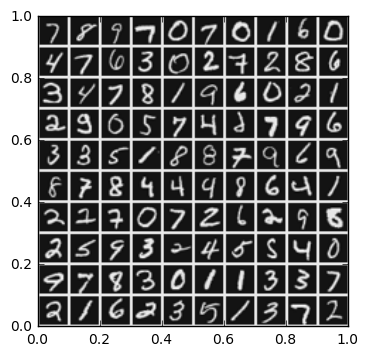

In [5]:
display_data(sel, padding=1, show=True)

## Part 2a: Vectorize Logistic Regression

The `lrCostFunction` function below provieds a vectorized implemention to compute cost and gradient, which is the same as it was implemented before as we've been using the vectorized implemention all along.

In [6]:
def sigmoid(z):
    """
    Compute sigmoid function.

    Parameters
    ----------
    z : array_like
        Variable for sigmoid function.

    Returns
    -------
    ndarray
        The sigmoid of each value of z.
    """
    g = 1 / (1 + np.exp(-z))
    return g


def lr_cost_function(theta, x, y, l):
    """
    Compute cost and gradient for logistic regression with regularization.

    Parameters
    ----------
    theta : ndarray
        Linear regression parameter, n by 1 matrix where n is the number of features.
    x : ndarray
        Training data, m by n matrix where m is the number of data samples.
    y : ndarray
        Labels, m by 1 matrix.
    l : float
        Regularization parameter.

    Returns
    -------
    J : numpy.float64
        The cost of using theta as the parameter for regularized logistic regression w.r.t. the parameters.
    grad: ndarray
        Partial derivatives of the cost w.r.t. each parameter in theta, n by 1 matrix.
    """
    (m, n) = x.shape
    theta = theta.reshape(n, 1)

    x_dot_theta = x.dot(theta)
    mask = np.eye(theta.shape[0])
    # Skip the theta[0, 0] parameter when performing regularization
    mask[0, 0] = 0

    j = 1.0 / m * (np.dot(-y.T, np.log(sigmoid(x_dot_theta))) - np.dot((1 - y).T, np.log(1 - sigmoid(x_dot_theta)))) \
        + 1.0 * l / (2 * m) * np.sum(np.power((mask.dot(theta)), 2))
    j = j.flatten()
    grad = 1.0 / m * np.dot((sigmoid(x_dot_theta) - y).T, x).T + 1.0 * l / m * (mask.dot(theta))

    return j[0], grad

Here is a test case for `lr_cost_function`: 

In [7]:
theta_t = np.array([-2, -1, 1, 2]).reshape(4, 1)
x_t = np.hstack((np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F') / 10.0))
y_t = np.array([1, 0, 1, 0, 1]).reshape(5, 1)
lambda_t = 3

j, grad = lr_cost_function(theta_t, x_t, y_t, lambda_t)

print 'Cost:', j
print 'Expected cost: 2.534819'
print 'Gradients: \n', grad
print 'Expected gradients: \n', '0.146561\n-0.548558\n0.724722\n1.398003\n'

Cost: 2.53481939611
Expected cost: 2.534819
Gradients: 
[[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]
Expected gradients: 
0.146561
-0.548558
0.724722
1.398003



## Part 2b: One-vs-All Training

The `one_vs_all` function below trains multiple logistic regression classifiers and returns all the classifiers in a matrix. 

In [8]:
import scipy.optimize as opt


def lr_cost_opt(theta, x, y, l):
    """
    Compute cost for logistic regression with regularization.

    Parameters
    ----------
    theta : ndarray
        Linear regression parameter, n by 1 matrix where n is the number of features.
    x : ndarray
        Training data, m by n matrix where m is the number of data samples.
    y : ndarray
        Labels, m by 1 matrix.
    l : float
        Regularization parameter.

    Returns
    -------
    J : numpy.float64
        The cost of using theta as the parameter for linear regression to fit the data points in x and y.
    """
    j, g = lr_cost_function(theta, x, y, l)
    return j


def lr_gradient_opt(theta, x, y, l):
    """
    Compute gradient for logistic regression with regularization.

    Parameters
    ----------
    theta : ndarray
        Linear regression parameter, n by 1 matrix where n is the number of features.
    x : ndarray
        Training data, m by n matrix where m is the number of data samples.
    y : ndarray
        Labels, m by 1 matrix.
    l : float
        Regularization parameter.

    Returns
    -------
    grad: ndarray
        Partial derivatives of the cost w.r.t. each parameter in theta, n by 1 matrix.
    """
    j, g = lr_cost_function(theta, x, y, l)
    return g.flatten()


def one_vs_all(x, y, num_labels, l):
    """
    Trains multiple logistic regression classifiers and returns all the classifiers in a matrix all_theta, where the
    i-th row of all_theta corresponds to the classifier for label i.

    Parameters
    ----------
    x : ndarray
        Training data, m by n matrix where m is the number of data samples.
    y : ndarray
        Labels, m by 1 matrix.
    num_labels : int
        Number of labels.
    l : float
        Regularization parameter.

    Returns
    -------
    all_theta : ndarray
         All classifiers where the i-th row of all_theta corresponds to the classifier for label i, num_labels by
         (n + 1) matrix.
    """
    m, n = x.shape
    all_theta = np.zeros((num_labels, n + 1))
    x = np.hstack((np.ones((m, 1)), x))
    initial_theta = np.zeros((n + 1, 1)).flatten()

    for i in range(0, 10):
        label = 10 if i == 0 else i
        result = opt.minimize(fun=lr_cost_opt, x0=initial_theta, args=(x, (y == label).astype(int), l), method='TNC',
                              jac=lr_gradient_opt)
        print 'one_vs_all(): label =', label, ', success =', result.success
        all_theta[i, :] = result.x

    return all_theta

Training one-vs-all logistic regression with the given data set may take a while.

In [9]:
l = 0.1
all_theta = one_vs_all(x, y, num_labels, l)

one_vs_all(): label = 10 , success = True
one_vs_all(): label = 1 , success = True
one_vs_all(): label = 2 , success = True
one_vs_all(): label = 3 , success = True
one_vs_all(): label = 4 , success = True
one_vs_all(): label = 5 , success = True
one_vs_all(): label = 6 , success = True
one_vs_all(): label = 7 , success = True
one_vs_all(): label = 8 , success = True
one_vs_all(): label = 9 , success = True


## Part 3: Predict for One-Vs-All

The `predict_one_vs_all` function below predicts the label for a trained one-vs-all classifier.

In [10]:
def predict_one_vs_all(all_theta, x):
    """
    Predict the label for a trained one-vs-all classifier.

    Parameters
    ----------
    all_theta : ndarray
         A matrix where the i-th row is a trained logistic regression theta vector for the i-th class.
    x : ndarray
        Training data, m by n matrix where m is the number of data samples.

    Returns
    -------
    p : ndarray
         The prediction for x, m by 1 array.
    """
    m, n = x.shape
    p = np.zeros((m, 1))
    x = np.hstack((np.ones((m, 1)), x))
    p = np.argmax(x.dot(all_theta.T), axis=1)
    p[p == 0] = 10
    return p.reshape(m, 1)

The accuracy on training set:

In [11]:
pred = predict_one_vs_all(all_theta, x)
print 'Training Set Accuracy:', np.mean(pred == y) * 100

Training Set Accuracy: 96.46
